## Introducción - De que trata esta notebook/Cálculos.

In [ ]:
# La forma de distribución del Score Privado se mantiene, más allá de cual sea la semilla. 
# Lo que cambia es su desplazamiento hacia arriba/abajo.

# La forma de distribución del Score Público cambia un poco más.
# Además, cambia su desplazamiento hacia arriba/abajo en un rango más amplio.

# El punto máximo en el Privado suele estar muy concentrado en 12.000.
# El punto máximo en el Público varía un poco más alrededor de 12.000.

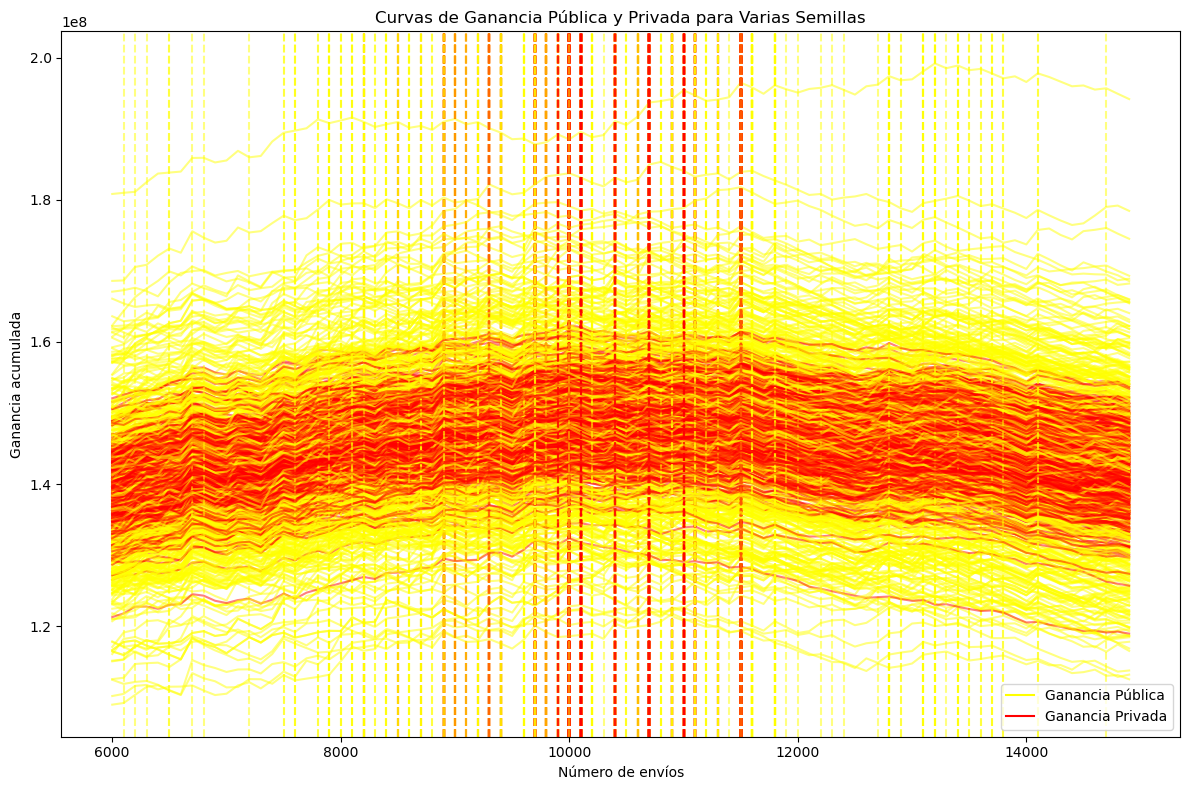

In [ ]:
# Enviando 20 semillas para distintos puntos de corte, la distribución de los promedios de las curvas del Público y 
# Privado se asemejan mucho entre sí. Esto me sirve para elegir el punto de corte óptimo. 

Modelo A.
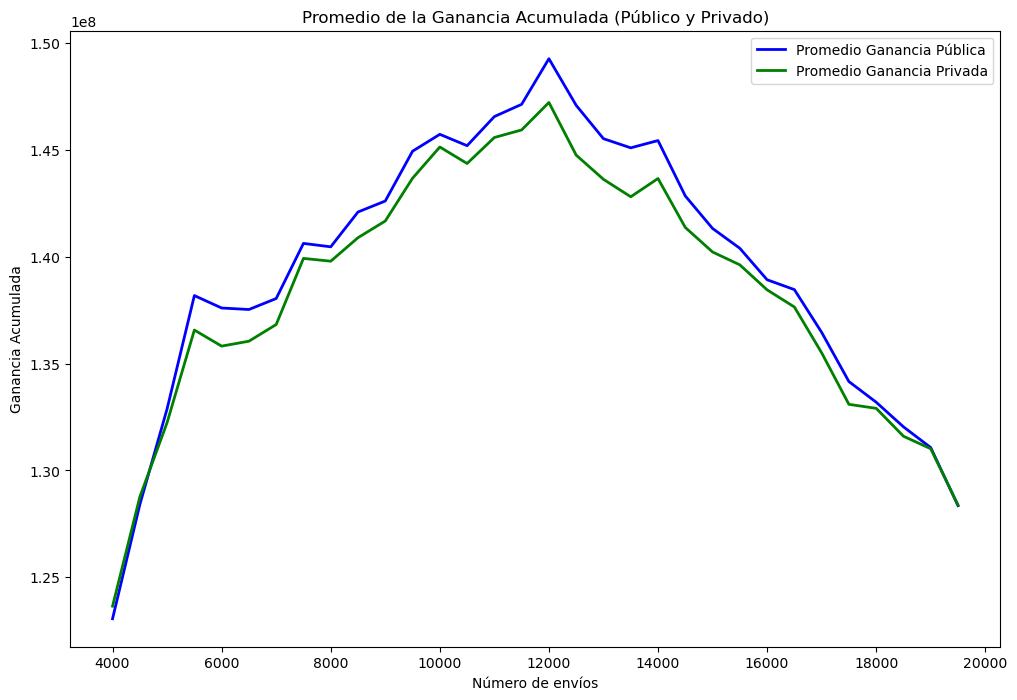
Modelo B.
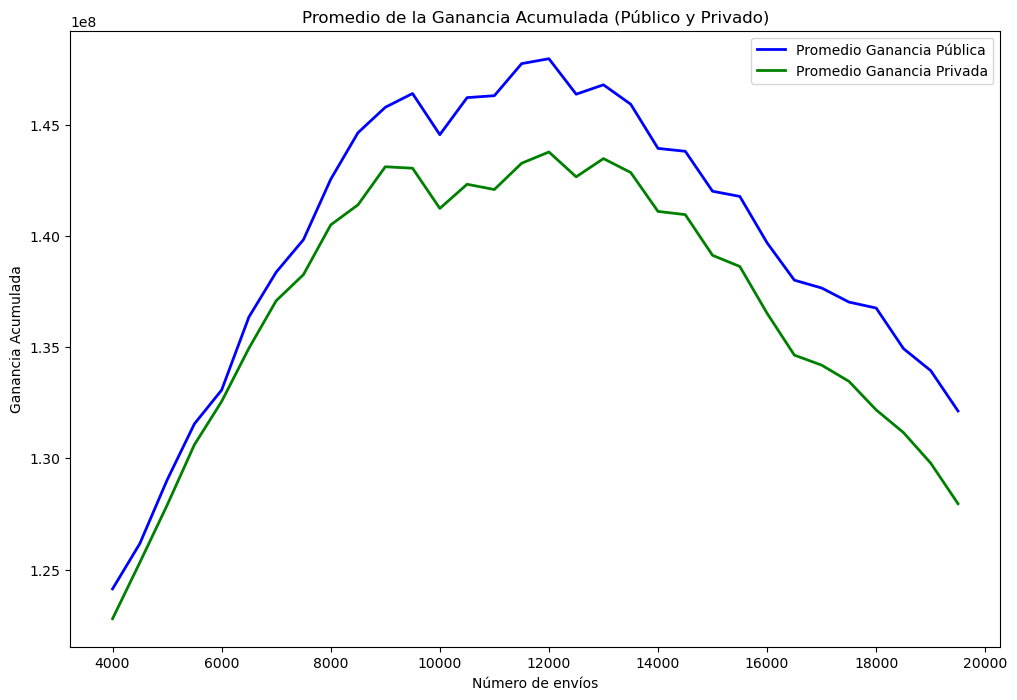

In [ ]:
# Enviando 500 semillas para un solo punto de corte, dicha ganancia promedio me coincide con 
# la ganancia promedio del Privado (ver foto). De todas formas, 100 semillas es un buen aproximador también.

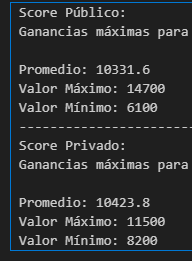

In [ ]:
""" Dado que tenemos solo 100 intentos por día...
1. Mandar 10 semillas (lo ideal son 20) por modelo de puntos de corte entre 8500 y 13500 cada 500 (lo ideal es 200)
buscando la forma de la distribución.

2. Tomar el punto de corte promedio máximo por modelo (máximo del privado), que será la línea vertical insesgada.

3. Luego, con dicho punto de corte, hacer 20 semillas (lo ideal son 100) por modelo para tomar el valor promedio
que se acercará al valor promedio de diferentes semillas de privado.

4. Escoger el modelo con el punto promedio máximo.

5. Escoger dicho modelo y dicho punto de corte máximo.
"""

In [2]:
envios_por_semilla_modelo = (13500-8500)/500

In [3]:
semillas = 10

In [4]:
cantidad_modelos = 3 # v2 -2, v2 -3, v2 -3 sin cprestamos_personales ni mprestamos_personales.

In [ ]:
cantidad_envios_por_modelo = envios_por_semilla_modelo * semillas
cantidad_envios_por_modelo

In [6]:
limite_kaggle_envios_diario = 100

In [ ]:
dias_mandados_ver_distribucion = cantidad_modelos * (cantidad_envios_por_modelo/limite_kaggle_envios_diario)
dias_mandados_ver_distribucion # Lunes, Martes y Miércoles.

In [8]:
# Jueves correr 20 semillas por modelo y punto de corte y tomar su promedio (60 envios).
# ------> Quedarme con el modelo y punto de corte con promedio total máximo.

## a. Modelo v2 -3 (Abril).

In [ ]:
#a. Importo librerías.
%run "./librerias.ipynb"

In [ ]:
#b. Importo constantes.
%run "./constantes.ipynb"

In [4]:
#c. Lectura de datos.
data = pd.read_csv(base_path+dataset_file_fe_menos_3)

In [5]:
#d. Importo el modelo.
model_lgb = lgb.Booster(model_file="./lgb_datos_abril_menos_3_v2.txt")

In [6]:
#e. Asignamos pesos y reclusterizamos.
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [7]:
#f. Dividimos entre conjuntos de datos.
train_data = data[data['foto_mes'] == mes_train_a]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [ ]:
#g. Recogemos los parámetros probados con Optuna.
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_731_lgbm_train_abril_menos_3_V2" # Primer dígito número de clase, segundo dígito df - cuanto, tercer dígito número de entrenamiento.

#ii. Creo el estudio.
study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

In [10]:
#h. Configuramos la cantidad de veces que vamos a subir cada curva de intentos (semillas).
cantidad_semillas = 10
semillas = [np.random.randint(0, 10000) for _ in range(cantidad_semillas)]

In [ ]:
#i. Entrenamos con Abril y predecimos Junio.
#i. Recorremos diferentes semillas para entrenar.
i= 0
for semilla in semillas:
    print("\n---------------------------------------")
    print("Semilla: {}.".format(semilla))
    #ii. Activamos la API para realizar envíos a Kaggle.
    api = KaggleApi()
    api.authenticate()
    #iii. Tomamos el mejor modelo y con eso entrenamos Abril.
    print("--> Mejores parámetros...")
    best_iter = study.best_trial.user_attrs["best_iter"]
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': study.best_trial.params['num_leaves'],
        'learning_rate': study.best_trial.params['learning_rate'],
        'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
        'feature_fraction': study.best_trial.params['feature_fraction'],
        'bagging_fraction': study.best_trial.params['bagging_fraction'],
        'seed': semilla,
        'verbose': 0
    }
    #iv. Adaptamos el dataset de entrenamiento.
    train_data = lgb.Dataset(X_train,
                            label=y_train_binaria2,
                            weight=w_train)
    #v. Entrenamos el modelo de Light GBM con los mejores hiperparámetros y la semilla aleatoria.
    print("--> Comienza el entrenamiento...")
    model_lgb = lgb.train(params,
                    train_data,
                    num_boost_round=best_iter)
    
    #vi. Predecimos Junio.
    predicciones = model_lgb.predict(X_test)
    #vii. Le pegamos la probabilidad de ser "BAJA" a cada cliente.
    X_test['Probabilidad'] = predicciones
    #viii. Ordenamos a los clientes por probabilidad de ser "BAJA" de forma descendente.
    tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)
    #ix. Genero una lista de distintos cortes candidatos, para enviar a Kaggle.
    cortes = range(8500,13500,500)
    #x. Generamos las distintas predicciones de clases a partir de los distintos cortes posibles.
    num_subida_kaggle = 1
    print("--> Comienzan los envíos a Kaggle...\n")
    for envios in cortes:
        #1. Le ponemos clase 1 ("BAJA") a los primeros "envios" con mayor probabilidad.
        tb_entrega['Predicted'] = 0
        tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
        resultados = tb_entrega[["numero_de_cliente", 'Predicted']].reset_index(drop=True)
        
        print("Cantidad de clientes {}".format(envios))
        #2. Guardamos el archivo para Kaggle.
        nombre_archivo = "K107_EK_3_0{}_{}.csv".format(num_subida_kaggle,semilla) #DF con -X meses, número de intento, número de semilla.
        ruta_archivo= "../../../exp/{}".format(nombre_archivo)
        resultados.to_csv(ruta_archivo, index=False)
        
        num_subida_kaggle += 1
        
        #3. Envío a Kaggle.
        #a. Defino los parámetros claves.
        mensaje = f'Archivo {nombre_archivo}. Abril DF. Semilla:{semilla},corte:{envios}' # Datos de Train, si está con Data Drifting o no, semilla y punto de corte de prueba.
        competencia = 'dm-ey-f-2024-primera'
        #c. Subo la Submission.
        while i<=19:
                api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
                print("Submission successful!")
                break
        else:
            print("Esperamos 30 segundos...")
            time.sleep(30)
            i= 0
        
    #d. Borramos la columna de predicciones anterior.
    X_test.drop(["Probabilidad"],axis=1,inplace=True)

In [1]:
#j. Análisis de las subidas a Kaggle.
#i. Eligiendo el mejor punto de corte.
# Dados las 9 semillas corridas, y los 10 diferentes puntos de corte, el promedio nos indica que el punto de corte
# más óptimo para este modelo es en 12.000 envíos. En tanto la distribución promedio del Público se asemeja a la
# distribución promedio del Privado, dicho punto de corte sería el mejor para la distribución promedio del Privado.

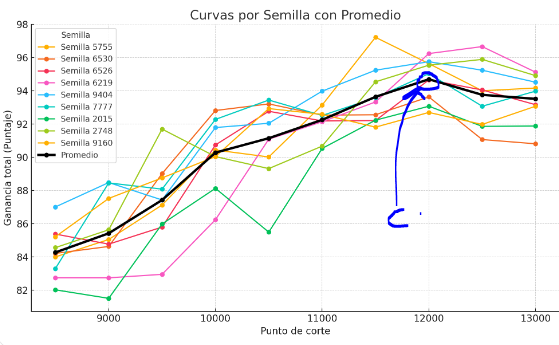
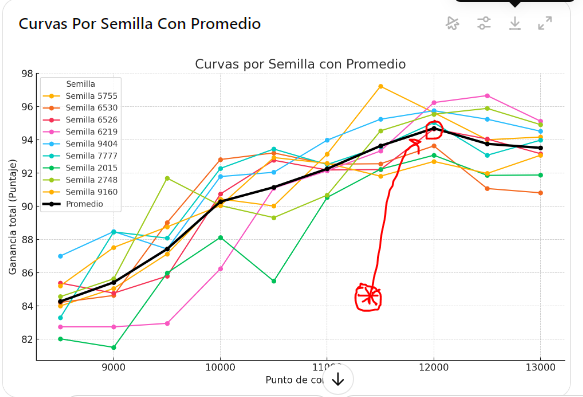

In [ ]:
#ii. Calculando la ganancia promedio para el Modelo 1 con el punto de corte de 12.000 (cuan hacia arriba/abajo está el Private).
# Voy a tomar las 10 semillas ya corridas + 90 nuevas.

In [10]:
#a. Configuramos la cantidad de veces que vamos a subir cada curva de intentos (semillas).
cantidad_semillas = 89
semillas = [np.random.randint(0, 10000) for _ in range(cantidad_semillas)]

In [15]:
semillas= semillas[20:]

In [ ]:
#i. Entrenamos con Abril y predecimos Junio.
#i. Recorremos diferentes semillas para entrenar.
i= 0
for semilla in semillas:
    i += 1
    print("\n---------------------------------------")
    print("Semilla: {}.".format(semilla))
    #ii. Activamos la API para realizar envíos a Kaggle.
    api = KaggleApi()
    api.authenticate()
    #iii. Tomamos el mejor modelo y con eso entrenamos Abril.
    print("--> Mejores parámetros...")
    best_iter = study.best_trial.user_attrs["best_iter"]
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': study.best_trial.params['num_leaves'],
        'learning_rate': study.best_trial.params['learning_rate'],
        'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
        'feature_fraction': study.best_trial.params['feature_fraction'],
        'bagging_fraction': study.best_trial.params['bagging_fraction'],
        'seed': semilla,
        'verbose': 0
    }
    #iv. Adaptamos el dataset de entrenamiento.
    train_data = lgb.Dataset(X_train,
                            label=y_train_binaria2,
                            weight=w_train)
    #v. Entrenamos el modelo de Light GBM con los mejores hiperparámetros y la semilla aleatoria.
    print("--> Comienza el entrenamiento...")
    model_lgb = lgb.train(params,
                    train_data,
                    num_boost_round=best_iter)
    
    #vi. Predecimos Junio.
    predicciones = model_lgb.predict(X_test)
    #vii. Le pegamos la probabilidad de ser "BAJA" a cada cliente.
    X_test['Probabilidad'] = predicciones
    #viii. Ordenamos a los clientes por probabilidad de ser "BAJA" de forma descendente.
    tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)
    #ix. Genero una lista de distintos cortes candidatos, para enviar a Kaggle.
    envios = 12000
    #x. Generamos las distintas predicciones de clases a partir de los distintos cortes posibles.
    print("--> Comienzan los envíos a Kaggle...\n")
    #1. Le ponemos clase 1 ("BAJA") a los primeros "envios" con mayor probabilidad.
    tb_entrega['Predicted'] = 0
    tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
    resultados = tb_entrega[["numero_de_cliente", 'Predicted']].reset_index(drop=True)

    #2. Guardamos el archivo para Kaggle.
    nombre_archivo = "K107_EK_3_12milcorte_{}.csv".format(semilla) #DF con -X meses, número de intento, número de semilla.
    ruta_archivo= "../../../exp/{}".format(nombre_archivo)
    resultados.to_csv(ruta_archivo, index=False)

    #3. Envío a Kaggle.
    #a. Defino los parámetros claves.
    mensaje = f'Archivo {nombre_archivo}. Abril DF. Semilla:{semilla},corte:{envios}' # Datos de Train, si está con Data Drifting o no, semilla y punto de corte de prueba.
    competencia = 'dm-ey-f-2024-primera'
    #c. Subo la Submission.
    while i<=19:
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
            break
    else:
        print("Esperamos 30 segundos...")
        time.sleep(30)
        api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
        print("Submission successful!")
        i= 1
        
    #d. Borramos la columna de predicciones anterior.
    X_test.drop(["Probabilidad"],axis=1,inplace=True)

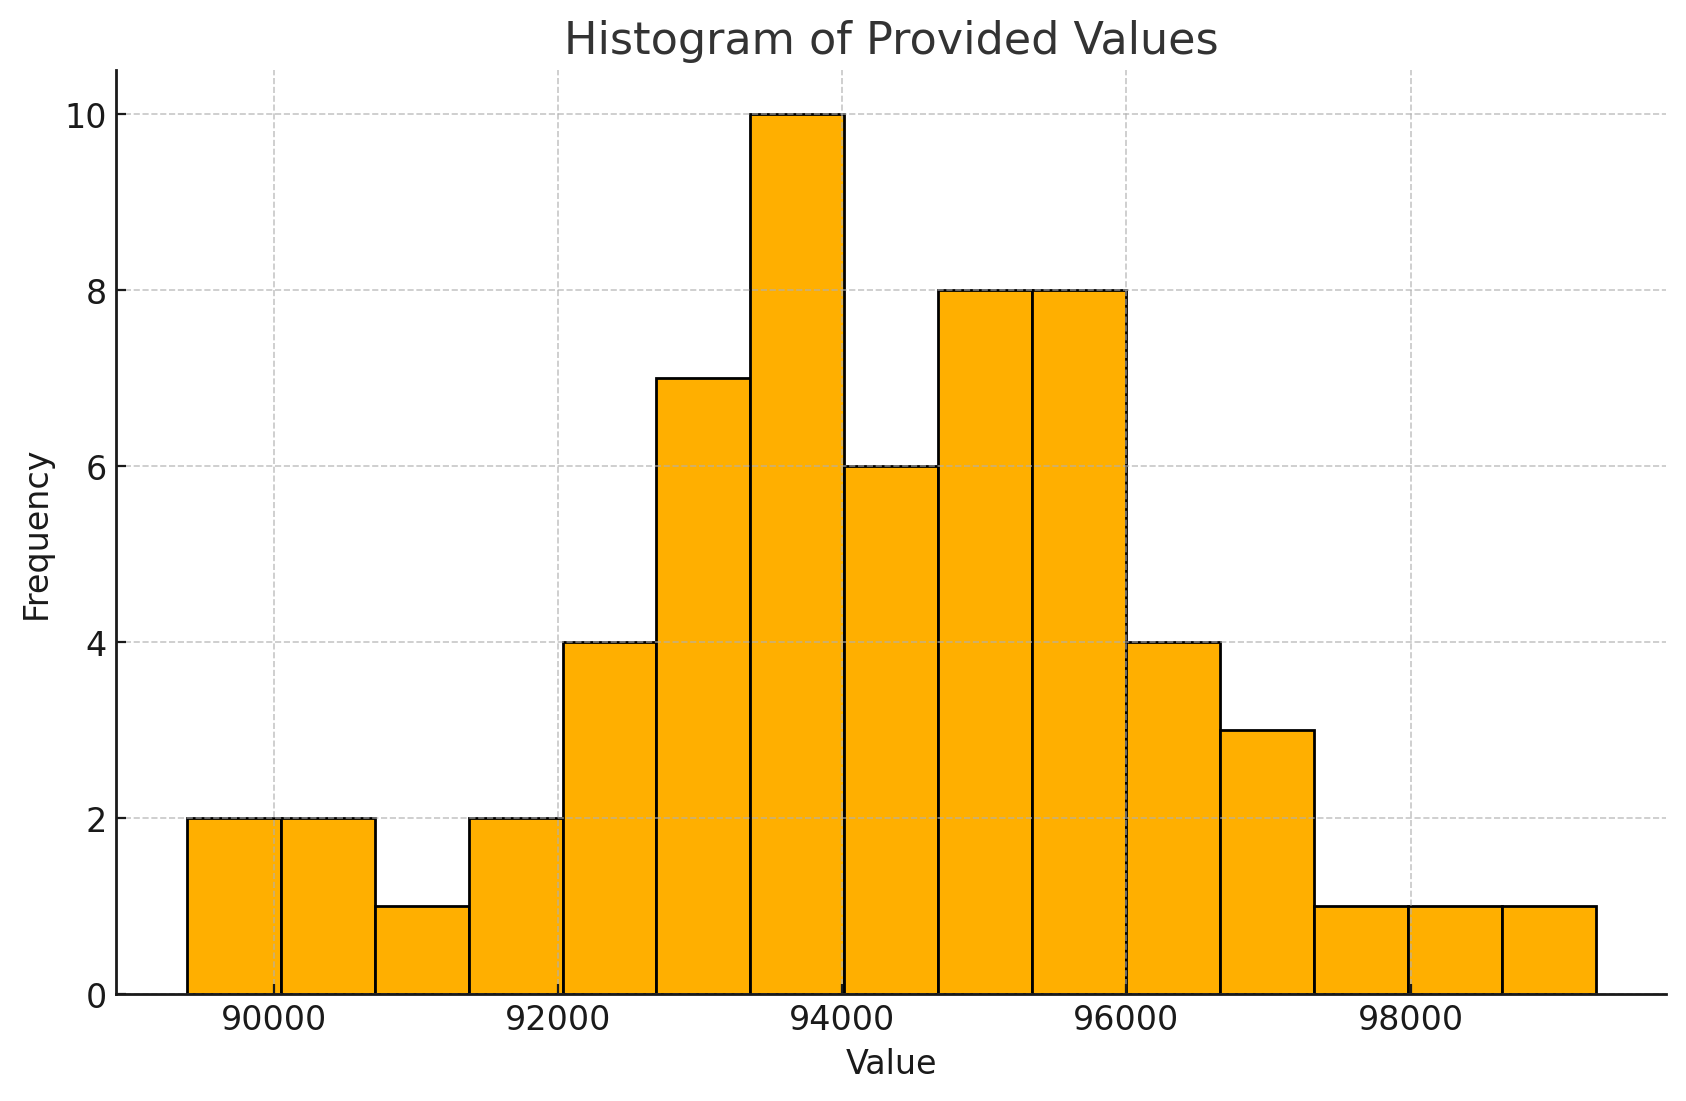

## b. Modelo v2 -3 (Abril) sin Prestamos Personales.

In [1]:
#a. Importo librerías.
%run "./librerias.ipynb"

c:\Users\c678456\AppData\Local\anaconda3\envs\dmeyf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#b. Importo constantes:
%run "./constantes.ipynb"

In [3]:
#c. Lectura de datos.
data = pd.read_csv(base_path+dataset_file_fe_menos_3)

In [4]:
#d. Elimino las columnas de préstamos personales.
columnas_de_interes_prestamos = data.filter(like='prestamos_personales').columns

data.drop(columnas_de_interes_prestamos,axis=1,inplace=True)

In [5]:
#e. Asignamos pesos y reclusterizamos.
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [6]:
#f. Dividimos entre conjuntos de datos.
train_data = data[data['foto_mes'] == mes_train_a]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [7]:
del data

In [8]:
#g. Recogemos los parámetros probados con Optuna.
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_731_lgbm_train_abril_menos_3_sin_prestamos" # Primer dígito número de clase, segundo dígito df - cuanto, tercer dígito número de entrenamiento.

#ii. Creo el estudio.
study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-09 18:51:11,452] Using an existing study with name 'exp_731_lgbm_train_abril_menos_3_sin_prestamos' instead of creating a new one.


In [ ]:
#h. Configuramos la cantidad de veces que vamos a subir cada curva de intentos (semillas).
#cantidad_semillas = 10
#semillas = [np.random.randint(0, 10000) for _ in range(cantidad_semillas)]

In [ ]:
#i. Entrenamos con Abril y predecimos Junio.
#i. Recorremos diferentes semillas para entrenar.
#i= 0
#for semilla in semillas:
#    print("\n---------------------------------------")
#    print("Semilla: {}.".format(semilla))
    #ii. Activamos la API para realizar envíos a Kaggle.
#    api = KaggleApi()
#    api.authenticate()
    #iii. Tomamos el mejor modelo y con eso entrenamos Abril.
#    print("--> Mejores parámetros...")
#    best_iter = study.best_trial.user_attrs["best_iter"]
#    params = {
#        'objective': 'binary',
#        'boosting_type': 'gbdt',
#        'first_metric_only': True,
#        'boost_from_average': True,
#        'feature_pre_filter': False,
#        'max_bin': 31,
#        'num_leaves': study.best_trial.params['num_leaves'],
#        'learning_rate': study.best_trial.params['learning_rate'],
#        'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
#        'feature_fraction': study.best_trial.params['feature_fraction'],
#        'bagging_fraction': study.best_trial.params['bagging_fraction'],
#        'seed': semilla,
#        'verbose': 0
#    }
    #iv. Adaptamos el dataset de entrenamiento.
#    train_data = lgb.Dataset(X_train,
#                            label=y_train_binaria2,
#                            weight=w_train)
    #v. Entrenamos el modelo de Light GBM con los mejores hiperparámetros y la semilla aleatoria.
#    print("--> Comienza el entrenamiento...")
#    model_lgb = lgb.train(params,
#                    train_data,
#                    num_boost_round=best_iter)
    
    #vi. Predecimos Junio.
#    predicciones = model_lgb.predict(X_test)
    #vii. Le pegamos la probabilidad de ser "BAJA" a cada cliente.
#    X_test['Probabilidad'] = predicciones
    #viii. Ordenamos a los clientes por probabilidad de ser "BAJA" de forma descendente.
#    tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)
    #ix. Genero una lista de distintos cortes candidatos, para enviar a Kaggle.
#    cortes = range(8500,13500,500)
    #x. Generamos las distintas predicciones de clases a partir de los distintos cortes posibles.
#    num_subida_kaggle = 1
#    print("--> Comienzan los envíos a Kaggle...\n")
#    for envios in cortes:
        #1. Le ponemos clase 1 ("BAJA") a los primeros "envios" con mayor probabilidad.
#        tb_entrega['Predicted'] = 0
#        tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
#        resultados = tb_entrega[["numero_de_cliente", 'Predicted']].reset_index(drop=True)
        
#        print("Cantidad de clientes {}".format(envios))
        #2. Guardamos el archivo para Kaggle.
#        nombre_archivo = "K107_EK_3_SPP_0{}_{}.csv".format(num_subida_kaggle,semilla) #DF con -X meses, número de intento, número de semilla.
#        ruta_archivo= "../../../exp/{}".format(nombre_archivo)
#        resultados.to_csv(ruta_archivo, index=False)
        
#        num_subida_kaggle += 1
        
        #3. Envío a Kaggle.
        #a. Defino los parámetros claves.
#        mensaje = f'Archivo {nombre_archivo}. Abril DF SPP. Semilla:{semilla},corte:{envios}' # Datos de Train, si está con Data Drifting o no, semilla y punto de corte de prueba.
#        competencia = 'dm-ey-f-2024-primera'
        #c. Subo la Submission.
#        while i<=19:
#                api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
#                print("Submission successful!")
#                break
#        else:
#            print("Esperamos 30 segundos...")
#            time.sleep(30)
#            i= 0
        
    #d. Borramos la columna de predicciones anterior.
#    X_test.drop(["Probabilidad"],axis=1,inplace=True)

In [ ]:
#j. Análisis de las subidas a Kaggle.
#i. Eligiendo el mejor punto de corte.
# Dados las 9 semillas corridas, y los 10 diferentes puntos de corte, el promedio nos indica que el punto de corte
# más óptimo para este modelo es en 12.000 envíos. En tanto la distribución promedio del Público se asemeja a la
# distribución promedio del Privado, dicho punto de corte sería el mejor para la distribución promedio del Privado.

Insertar imagen

In [ ]:
#ii. Calculando la ganancia promedio para el Modelo 1 con el punto de corte de 12.000 (cuan hacia arriba/abajo está el Private).
# Voy a tomar las 10 semillas ya corridas + 90 nuevas.

In [17]:
#a. Configuramos la cantidad de veces que vamos a subir cada curva de intentos (semillas).
cantidad_semillas = 60
semillas = [np.random.randint(0, 10000) for _ in range(cantidad_semillas)]

In [20]:
#i. Entrenamos con Abril y predecimos Junio.
#i. Recorremos diferentes semillas para entrenar.
i= 0
for semilla in semillas:
    i += 1
    print("\n---------------------------------------")
    print("Semilla: {}.".format(semilla))
    #ii. Activamos la API para realizar envíos a Kaggle.
    api = KaggleApi()
    api.authenticate()
    #iii. Tomamos el mejor modelo y con eso entrenamos Abril.
    print("--> Mejores parámetros...")
    best_iter = study.best_trial.user_attrs["best_iter"]
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': study.best_trial.params['num_leaves'],
        'learning_rate': study.best_trial.params['learning_rate'],
        'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
        'feature_fraction': study.best_trial.params['feature_fraction'],
        'bagging_fraction': study.best_trial.params['bagging_fraction'],
        'seed': semilla,
        'verbose': 0
    }
    #iv. Adaptamos el dataset de entrenamiento.
    train_data = lgb.Dataset(X_train,
                            label=y_train_binaria2,
                            weight=w_train)
    #v. Entrenamos el modelo de Light GBM con los mejores hiperparámetros y la semilla aleatoria.
    print("--> Comienza el entrenamiento...")
    model_lgb = lgb.train(params,
                    train_data,
                    num_boost_round=best_iter)
    
    #vi. Predecimos Junio.
    predicciones = model_lgb.predict(X_test)
    #vii. Le pegamos la probabilidad de ser "BAJA" a cada cliente.
    X_test['Probabilidad'] = predicciones
    #viii. Ordenamos a los clientes por probabilidad de ser "BAJA" de forma descendente.
    tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)
    #ix. Genero una lista de distintos cortes candidatos, para enviar a Kaggle.
    envios = 11750
    #x. Generamos las distintas predicciones de clases a partir de los distintos cortes posibles.
    print("--> Comienzan los envíos a Kaggle...\n")
    #1. Le ponemos clase 1 ("BAJA") a los primeros "envios" con mayor probabilidad.
    tb_entrega['Predicted'] = 0
    tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
    resultados = tb_entrega[["numero_de_cliente", 'Predicted']].reset_index(drop=True)

    #2. Guardamos el archivo para Kaggle.
    nombre_archivo = "K107_EK_3_SPP_11750corte_{}.csv".format(semilla) #DF con -X meses, número de intento, número de semilla.
    ruta_archivo= "../../../exp/{}".format(nombre_archivo)
    resultados.to_csv(ruta_archivo, index=False)

    #3. Envío a Kaggle.
    #a. Defino los parámetros claves.
    mensaje = f'Archivo {nombre_archivo}. Abril DF SPP. Semilla:{semilla},corte:{envios}' # Datos de Train, si está con Data Drifting o no, semilla y punto de corte de prueba.
    competencia = 'dm-ey-f-2024-primera'
    #c. Subo la Submission.
    while i<=19:
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
            break
    else:
        print("Esperamos 30 segundos...")
        time.sleep(30)
        api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
        print("Submission successful!")
        i= 1
        
    #d. Borramos la columna de predicciones anterior.
    X_test.drop(["Probabilidad"],axis=1,inplace=True)


---------------------------------------
Semilla: 8329.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.30MB/s]


Submission successful!

---------------------------------------
Semilla: 2991.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:03<00:00, 549kB/s] 


Submission successful!

---------------------------------------
Semilla: 1713.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.36MB/s]


Submission successful!

---------------------------------------
Semilla: 751.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.35MB/s]


Submission successful!

---------------------------------------
Semilla: 199.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.32MB/s]


Submission successful!

---------------------------------------
Semilla: 3637.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:02<00:00, 956kB/s]


Submission successful!

---------------------------------------
Semilla: 4080.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.34MB/s]


Submission successful!

---------------------------------------
Semilla: 8258.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:02<00:00, 1.05MB/s]


Submission successful!

---------------------------------------
Semilla: 2615.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.28MB/s]


Submission successful!

---------------------------------------
Semilla: 3986.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.29MB/s]


Submission successful!

---------------------------------------
Semilla: 7375.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.29MB/s]


Submission successful!

---------------------------------------
Semilla: 109.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.23MB/s]


Submission successful!

---------------------------------------
Semilla: 962.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.37MB/s]


Submission successful!

---------------------------------------
Semilla: 7936.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.28MB/s]


Submission successful!

---------------------------------------
Semilla: 9085.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.32MB/s]


Submission successful!

---------------------------------------
Semilla: 5556.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.35MB/s]


Submission successful!

---------------------------------------
Semilla: 2859.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.35MB/s]


Submission successful!

---------------------------------------
Semilla: 442.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.28MB/s]


Submission successful!

---------------------------------------
Semilla: 3263.
--> Mejores parámetros...
--> Comienza el entrenamiento...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.20MB/s]


Submission successful!

---------------------------------------
Semilla: 9473.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...

Esperamos 30 segundos...


100%|██████████| 2.08M/2.08M [00:01<00:00, 1.24MB/s]


Submission successful!

---------------------------------------
Semilla: 5636.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.28MB/s]


Submission successful!

---------------------------------------
Semilla: 9055.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.34MB/s]


Submission successful!

---------------------------------------
Semilla: 9436.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.29MB/s]


Submission successful!

---------------------------------------
Semilla: 9509.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.37MB/s]


Submission successful!

---------------------------------------
Semilla: 1594.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.36MB/s]


Submission successful!

---------------------------------------
Semilla: 4662.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.30MB/s]


Submission successful!

---------------------------------------
Semilla: 8174.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.31MB/s]


Submission successful!

---------------------------------------
Semilla: 4558.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.54MB/s]


Submission successful!

---------------------------------------
Semilla: 4852.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.30MB/s]


Submission successful!

---------------------------------------
Semilla: 3494.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.28MB/s]


Submission successful!

---------------------------------------
Semilla: 7881.
--> Mejores parámetros...
--> Comienza el entrenamiento...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.26MB/s]


Submission successful!

---------------------------------------
Semilla: 5813.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.29MB/s]


Submission successful!

---------------------------------------
Semilla: 9189.
--> Mejores parámetros...
--> Comienza el entrenamiento...
--> Comienzan los envíos a Kaggle...



100%|██████████| 2.08M/2.08M [00:01<00:00, 1.30MB/s]


Submission successful!

---------------------------------------
Semilla: 8153.
--> Mejores parámetros...
--> Comienza el entrenamiento...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


KeyboardInterrupt: 

In [ ]:
#12.000 de corte.

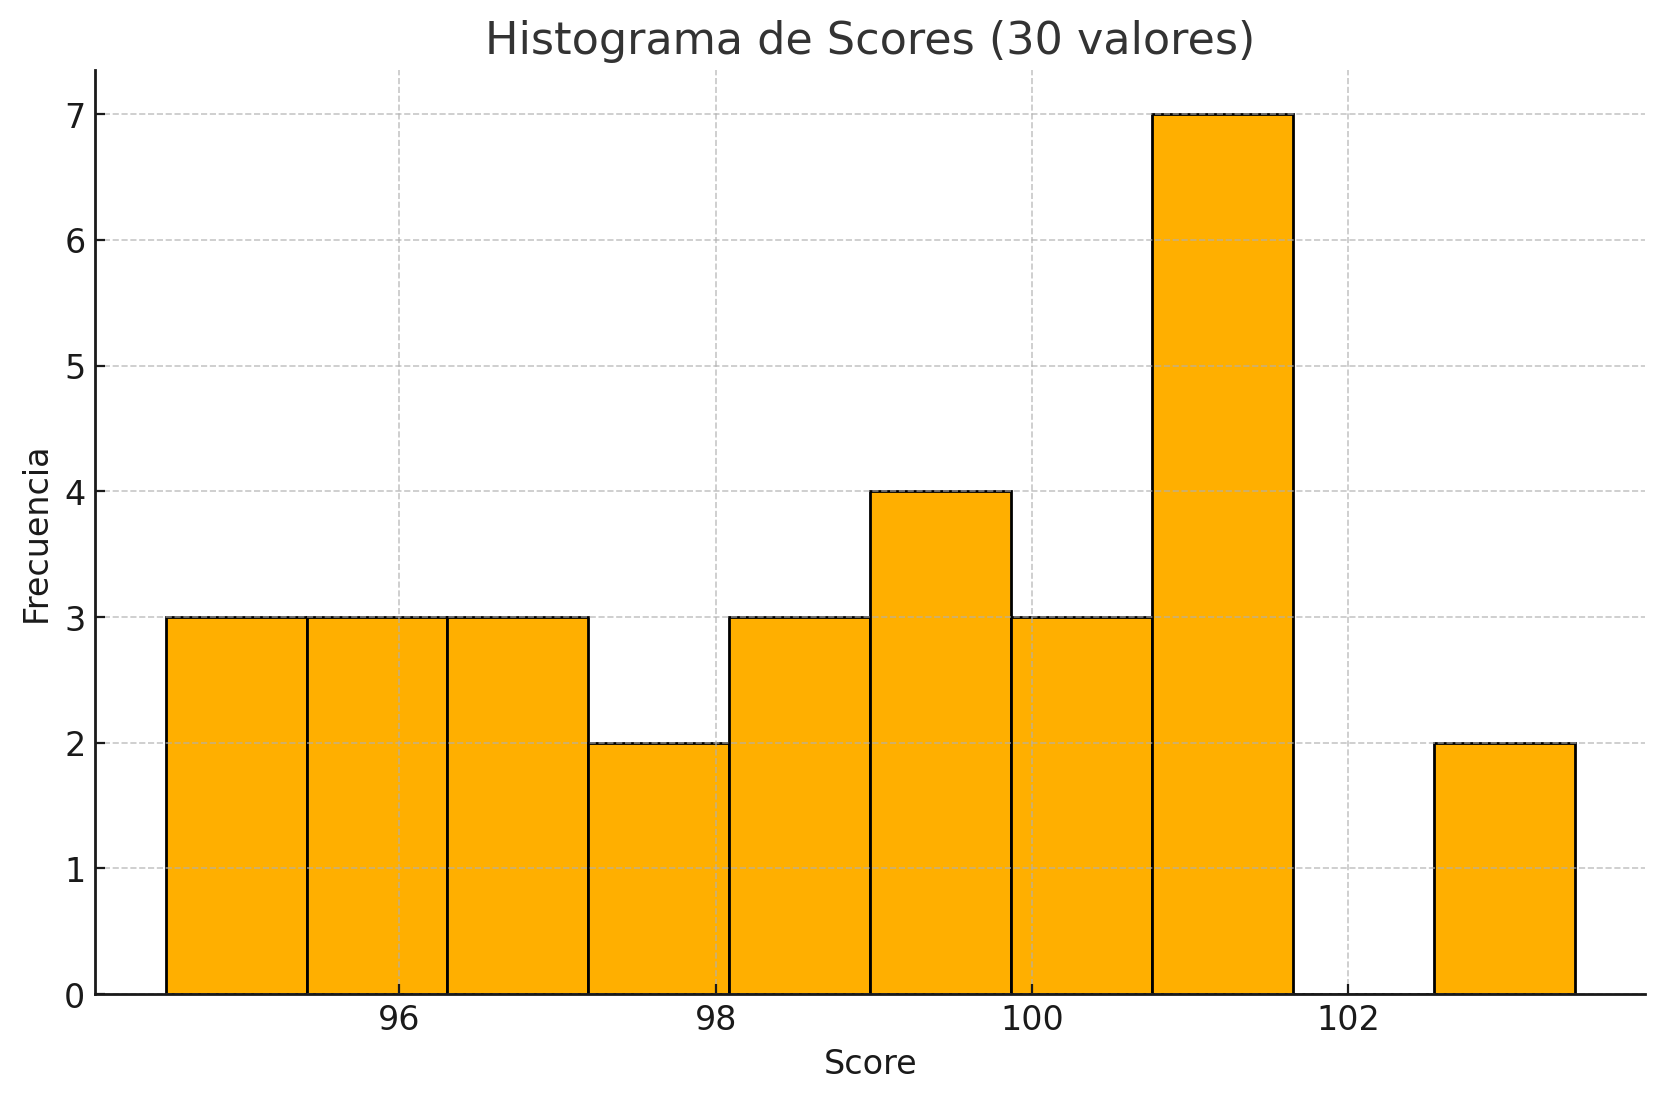

In [ ]:
#11.750.

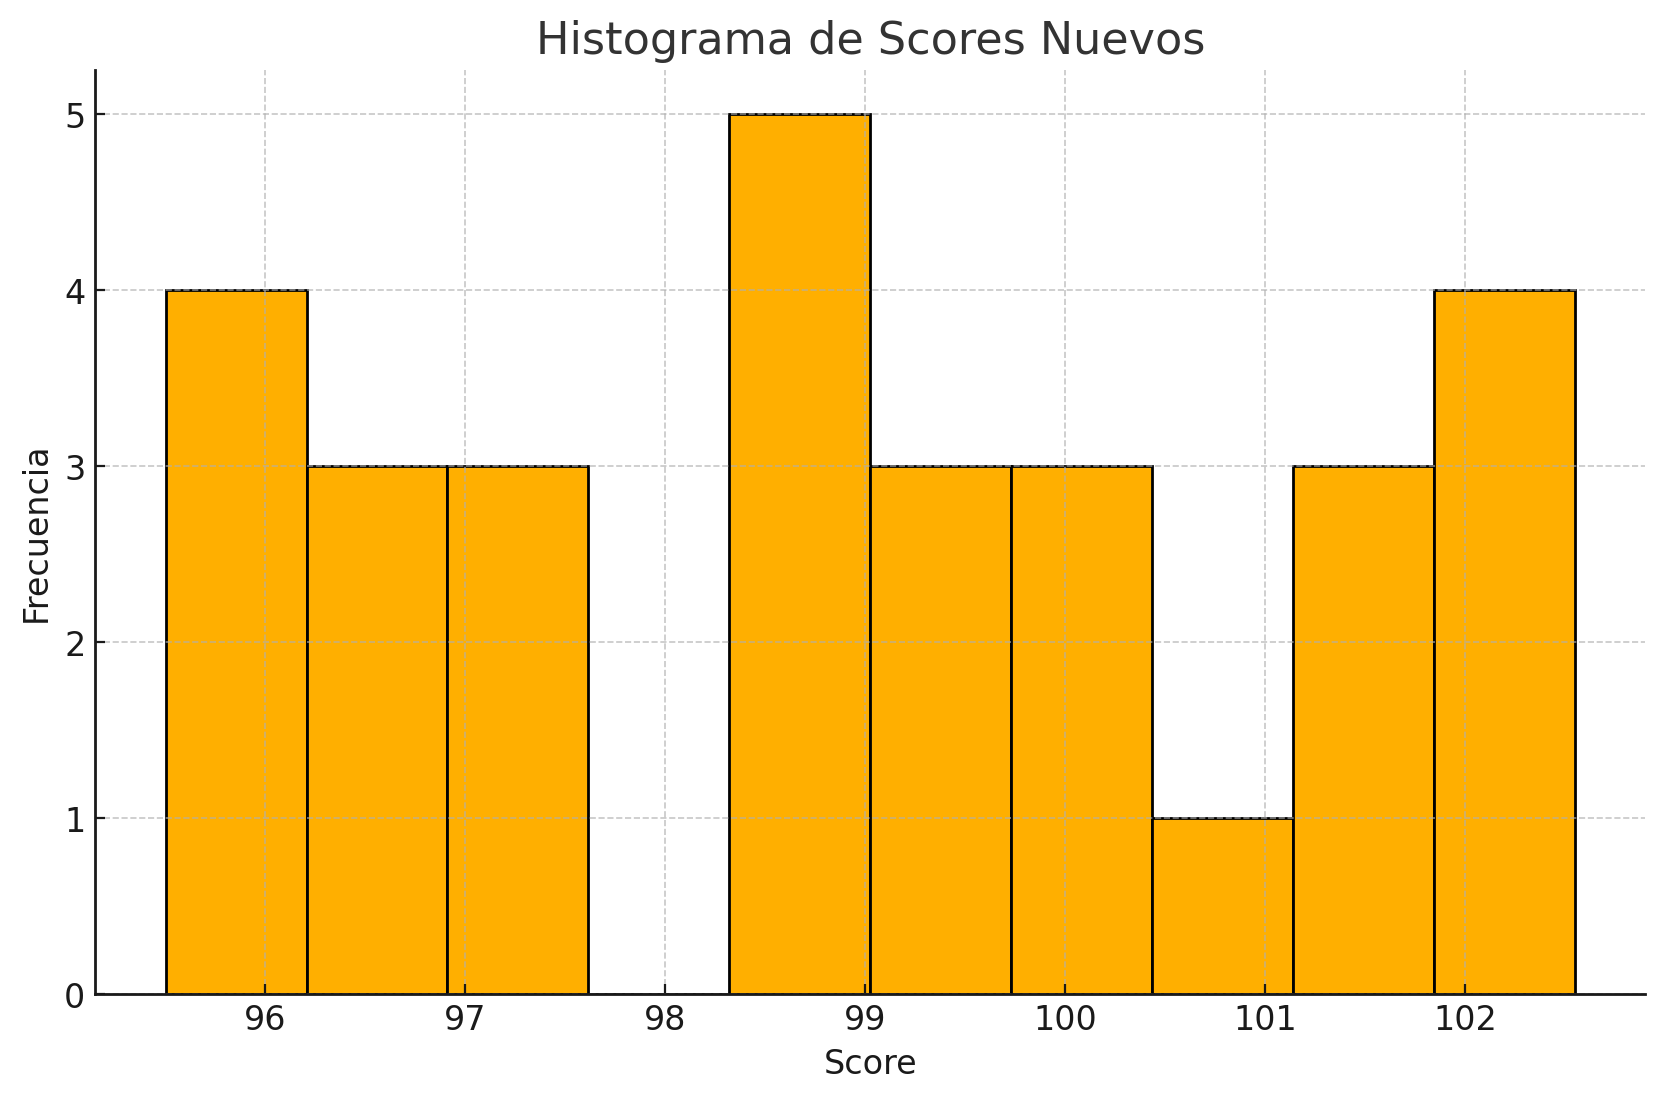